# Import Statements

In [19]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [1]:
import sys
sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu") 
sys.path.append("../../callpyff")   # talk to the stimuli
sys.path.append("../../nftools")  # handy stuff needed for NF
sys.path.append("../../wyrm")  # real-time data analysis

import time
import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import easygui
import mne
import re
import pickle
import dynarray
import random
import libmushu

from IPython.display import clear_output
from callpyff import bcinetwork, bcixml 
from scipy import signal
import logging  # set log level
logging.basicConfig(level=logging.WARNING)

from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra  
from nftools import camera

from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

from wyrm import signaltracking
from wyrm import filtering
from wyrm.types import RingBuffer

from numpy.linalg import multi_dot
from sklearn.decomposition import FastICA
from collections import deque

import importlib
import warnings
warnings.filterwarnings('ignore')

import ipdb

# Memory Monitoring Function

In [2]:
import os, psutil
def monitor_memory():
    pid = os.getpid()
    ps = psutil.Process(pid)
    memoryUse = ps.memory_info()
    return memoryUse.rss/1e6

# Define and Configure Amplifier

In [3]:
amp = libmushu.get_amp('bpamp')

In [4]:
# Configure the amp
amp.configure(remotecontrol=True,
              recorderip='20.100.0.3',
              recorderport=51244,
              pathtoworkspace='C:\\Vision\\Workfiles\\NF_64chEEG.rwksp',
              experimentnumber='Pre-Run01',
              subjectid='0001',
              n_channels=64,
              fs=5000)

connecting to 20.100.0.3 port 6700
sending b'1C:\\Vision\\Workfiles\\NF_64chEEG.rwksp'
sending b'2Pre-Run01'
sending b'30001'
sending b'4'
sending b'M'


# Set up BCI Network

In [5]:
bcinet = bcinetwork.BciNetwork('20.100.0.2', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [6]:
feedbacks = bcinet.getAvailableFeedbacks()
print(feedbacks)

['TestD2', 'MovingRhomb', 'LibetClock', 'BrainWaveTraining_II', 'TobiQLAdapter', 'Lesson04', 'EyetrackerRawdata', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'StopVigilanceTask', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'Lesson01', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'RestingState', 'NFBasicThermometer', 'RSVPSpeller', 'CenterSpellerVE', 'MultiVisualOddball', 'Lesson01b', 'GoalKeeper', 'EEGfMRILocalizer', 'Oddball', 'StroopFeedback', 'ERPMatrix', 'VisualOddballVE', 'Lesson05', 'Lesson06', 'VisualOddball', 'Lesson02', 'Lesson03']


# Main NF/RS Function

In [7]:
def nf_trial(task, thr=None, count=0):
    # %matplotlib qt5  
    plt.ion()  # enable widget plots & interactive plots
    data_length = np.linspace(0,600*5000,num=600*5000)
    fs=5000.
    time_in_plot=6
    sy1=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))
    sy2=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))
    sy3=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))
    sy4=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))
    channel_to_plot=0
    sx=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))
    if task==1:
        bcinet.send_init('BrainWaveTraining_II')
    elif task==0:
        bcinet.send_init('RestingState')
        bcinet.send_signal(bcixml.BciSignal({'EYESCLOSED_TIME': 300.0},None, bcixml.INTERACTION_SIGNAL))
    c=camera.DoCamera(); c.start()
    bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))
    
    # if on wrong screen:
    bcinet.send_signal(bcixml.BciSignal({'MONITOR_DISPLAYONSCREEN': 1},None, bcixml.INTERACTION_SIGNAL)) 
    bcinet.play()
    bcinet.send_signal(bcixml.BciSignal({'emgThrContainer': 0.1}, None, bcixml.CONTROL_SIGNAL))
    amp.start()
    
    importlib.reload(signaltracking)

    # from wyrm import signaltracking
    eegfilter = filtering.bwBPF(12,15)
    #icafilter = filtering.bwBPF(1,35)
    emgfilter = filtering.bwHPF(50)
    # smoother = filtering.bwExponentialSmoother(0.998)
    # smoother = filtering.bwLPF(2,order=2)
    smoother_eeg = filtering.bwSimpleAverager(300,2)
    smoother_emg = filtering.bwSimpleAverager(300,2)

    track_for_eeg_stimuli = signaltracking.sending_to_nfstim(thr=1.0, dur=0.20, feedback_type='eeg', max4audio=1.2, bcinet=bcinet, st_scaling=10)
    track_for_emg_stimuli = signaltracking.sending_to_nfstim(thr=50, dur=0.15, feedback_type='emg', bcinet=bcinet, st_scaling=350)

    l=LoopState(); l.start()
    alld=dynarray.DynamicArray((None, 2)) 
    alld_ica=dynarray.DynamicArray((None, len(amp.get_channels()))) # data
    allm=[]     # markers
    dts,sent=[],[]
    markeroffset = 0  # needed to store all data in one big mat/vector
    t0=time.time()
    curTime=time.time()
    totalTime = 500
    st=''
    
    fig=plt.figure(figsize=(20,12))  # plotting...
    th=fig.suptitle('', fontsize=16)
    ah1=fig.add_subplot(211)
    ah2=fig.add_subplot(212)
    
    l1, = ah1.plot(sx, sy1, color='b', label='Raw')
    l2, = ah1.plot(sx, sy2, color='r', label='Corrected')
    l3, = ah2.plot(sx, sy3, color='b', label='Raw')
    l4, = ah2.plot(sx, sy4, color='r', label='Corrected')
    
    x_data=0
    while l.get_state() != 'Stop' or curTime < totalTime: 
   
        # keep track of time:
        curTime = time.time()
        sfreq = 5000
        ch_names = amp.get_channels()
        markTime=time.time()
        updateTime = 0.01
        rb = RingBuffer(1.0 * 1000)
        # this is where you get the data
        data, marker, annotations = amp.get_data()
        #ipdb.set_trace()
    
        if data.shape[0] > 0:  # this is crucual for remembering filter state.
        
            cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
            ch_names_copy = ch_names.copy()
            
            
            if count == 0:
                cnt_removed = proc.remove_channels(cnt, ['ECG'])
                cnt_corr = multi_dot([pca_comps.T, M, S, M_inv, pca_comps, cnt_removed.data.T]).T
                #ipdb.set_trace()
                # trouble shooting
                test = proc.select_channels(cnt, ['C3','C4'])           
                ch_names_copy.pop(31)
                # ipdb.set_trace()
                cnt_corrected = io.convert_mushu_data(cnt_corr, marker, sfreq, ch_names_copy)
                #ipdb.set_trace()
                eeg_cnt = proc.select_channels(cnt_corrected, ['C3','C4'])
                #ipdb.set_trace()
            elif count == 1:
                eeg_cnt = proc.select_channels(cnt, ['C3','C4'])
                #ipdb.set_trace()                
                
            # preprocessing stream for EEG
            # ipdb.set_trace()
            f_eeg_cnt = eegfilter.apply(eeg_cnt)  # so filter it according to specified above
            af_eeg_cnt = proc.absolute(f_eeg_cnt)
            saf_eeg_cnt = smoother_eeg.apply(af_eeg_cnt)
 
        
            dts.append(saf_eeg_cnt.data.shape[0])
            
        
            # communications with the st-stim computer
            tf, audioTF = track_for_eeg_stimuli.check_above_threshold(saf_eeg_cnt)  # sends markers (should be fast)
            s = track_for_eeg_stimuli.send_data_signal(saf_eeg_cnt) # sends the signal (should also be fast!)
            sent.append(s)
             
            # do the EMG:
            emg_cnt = proc.select_channels(cnt, ['O1','O2'])
            f_emg_cnt = emgfilter.apply(emg_cnt)  # so filter it according to specified above
            af_emg_cnt = proc.absolute(f_emg_cnt)
            saf_emg_cnt = smoother_emg.apply(af_emg_cnt)
        
            tfemg, audioTFemg = track_for_emg_stimuli.check_above_threshold(saf_emg_cnt)  # sends markers (should be fast)
            semg = track_for_emg_stimuli.send_data_signal(saf_emg_cnt) # sends the signal (should also be fast!)
            
            if count==0:
                
                eb_data = cnt.data[:,channel_to_plot]
                ch_c3 = cnt.data[:, 4]
                cnt_removed = proc.remove_channels(cnt, ['ECG'])
                
                #f_ica_cnt = icafilter.apply(cnt_removed)  # so filter it according to specified above
                #af_ica_cnt = proc.absolute(f_ica_cnt)
                #saf_ica_cnt = smoother_eeg.apply(af_ica_cnt)
                
                data_corrected = multi_dot([pca_comps.T, M, S, M_inv, pca_comps, cnt_removed.data.T])
                #data_corrected = multi_dot([pca_comps.T, M, S, M_inv, pca_comps, saf_ica_cnt.data.T])
                
                sy1.extend(eb_data) 
                sy2.extend(data_corrected[channel_to_plot,:])
                sy3.extend(ch_c3)
                sy4.extend(data_corrected[4,:])
                
                sx.extend(data_length[x_data:x_data+len(eb_data)]/fs)
        
                l1.set_ydata(sy1)  
                l2.set_ydata(sy2)
                l3.set_ydata(sy3)
                l4.set_ydata(sy4)
            
                l1.set_xdata(sx)
                l2.set_xdata(sx)
                l3.set_xdata(sx)
                l4.set_xdata(sx)
        
                msy1=np.mean(sy1)
                msy2=np.mean(sy2)
                msy3=np.mean(sy3)
                msy4=np.mean(sy4)
         
                ah1.set_ylim(-400+msy1, 450+msy1)
                ah1.set_xlim(min(sx), max(sx))
                ah2.set_ylim(-350+msy3, 400+msy3)
                ah2.set_xlim(min(sx), max(sx))
        
                x_data += len(eb_data)
        
                fig.canvas.draw()
                fig.canvas.flush_events()
            
            
            alld.extend(eeg_cnt.data)
            alld_ica.extend(data)
            
            for m in marker:
                allm.append([m[0] + markeroffset, m[1]])
            markeroffset += cnt.data.shape[0] / float(sfreq) * 1000.
        
            # append to ringbuffer, so we can calculate features later on on the last N secs/samples of data.
            rb.append(f_eeg_cnt)

            # do the following every 0.1 msec - with with the ringbuffer:
            if curTime - markTime > updateTime:
                # do Stuff
                markTime = curTime
                print('Data is coming in - time = %f' % (curTime - t0))
                str1 = 'Playing Back - time = %f' % (curTime - t0)
                str2 = 'Length Markers: %d' % len(allm)
                str3 = '%d, %d' % data.shape

                # th.set_text(str1 + '\n' + str2 + '\n' +str3)
    amp.stop()   
    
    del(alld)
    
    return alld_ica, ch_names, sfreq


    

# Obtain first resting-state recording

In [9]:
mprun -f nf_trial nf_trial(0, count=1)

SyntaxError: invalid syntax (<ipython-input-9-f0a9e41191c8>, line 1)

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "../../nftools/nftools/camera.py", line 45, in run
    with Telnet(self.ip, self.port) as tn:
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/telnetlib.py", line 218, in __init__
    self.open(host, port, timeout)
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/telnetlib.py", line 234, in open
    self.sock = socket.create_connection((host, port), timeout)
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/socket.py", line 724, in create_connection
    raise err
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/socket.py", line 713, in create_connection
    sock.connect(sa)
OSError: [Errno 113] No route to host



FLIPPING/GOING THE THE MIDDLE AGAIN
FLIPPING/GOING THE THE MIDDLE AGAIN
loop is stopped!
amplifier stopped!


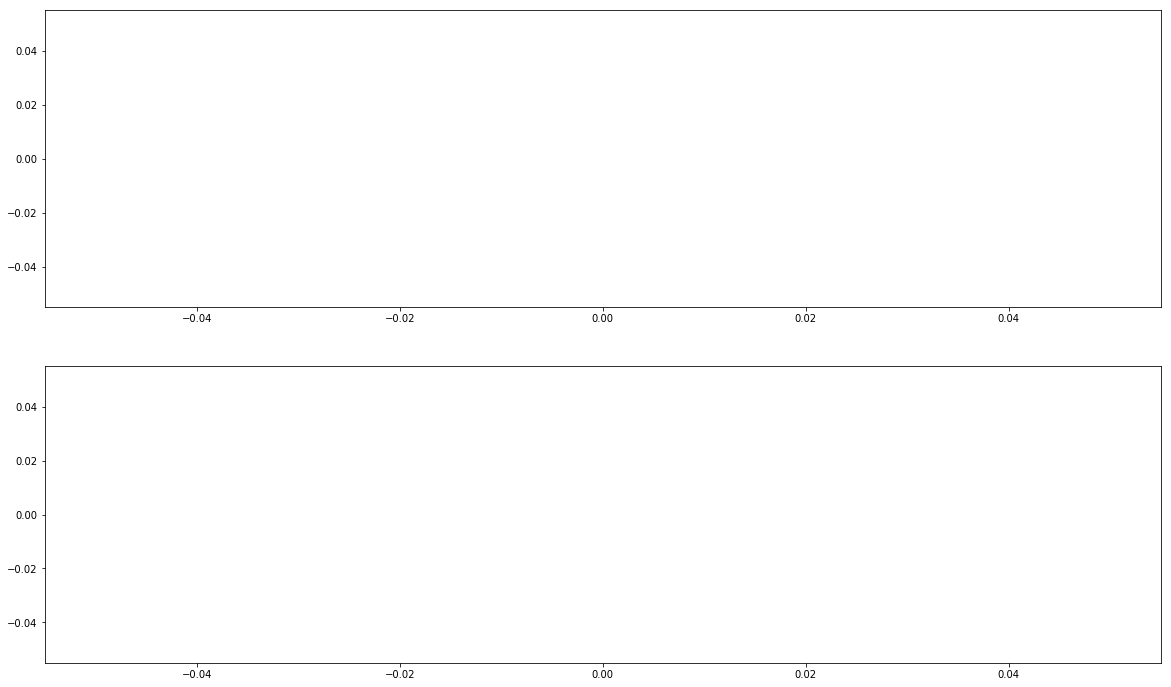

In [8]:
alld_ica, ch_names, sfreq = nf_trial(0, count=1)

# Perform ICA

In [9]:
#alld_ica[:,:] /= 1e6
alld_ica.shrink_to_fit()

raw = convert_alld_allm_to_mne(alld_ica, [], ch_names, sfreq)  # covert to MNE

raw.drop_channels(['ECG'])
raw.resample(1000, npad="auto")
#raw.set_eeg_reference('average', projection=True)
#raw.apply_proj()
raw.filter(1., 35., n_jobs=1, fir_design='firwin')
raw.load_data()

ica = mne.preprocessing.ICA(method="infomax", random_state=1)
ica.fit(raw)
%matplotlib qt
ica.plot_sources(inst=raw)
ica.plot_components(inst=raw)
ica_comps = ica.get_sources(inst=raw).get_data()
 
blks = raw.get_data().T
pca_comps = ica.pca_components_
M = ica.mixing_matrix_
M_inv = ica.unmixing_matrix_
S = np.identity(M.shape[0])

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
Creating RawArray with float64 data, n_channels=64, n_times=1011000
    Range : 0 ... 1010999 =      0.000 ...   202.200 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=1011000
    Range : 0 ... 1010999 =      0.000 ...   202.200 secs
Ready.
> /home/nfcontrol/nf/nf-rtime/nftools/nftools/analysis.py(148)convert_alld_allm_to_mne()
    147     # create the marker matrix:
--> 148     if len(allm)>0:
    149         raw.add_events(ev_arr)



ipdb>  c


Setting up band-pass filter from 1 - 35 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 8.8 Hz
Filter length of 3301 samples (3.301 sec) selected
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 63
 
Fitting ICA took 75.8s.


ImportError: /usr/lib/libharfbuzz.so.0: undefined symbol: FT_Done_MM_Var

# Define Selection Matrix

In [19]:
S[[0,1],:] = 0

# Correct Data for Artefacts

In [20]:
blks = np.delete(blks, -1, 1).T # removing STIM channel
data_corr = multi_dot([pca_comps.T, M, S, M_inv, pca_comps, blks])
np.save('data_corr.npy', data_corr)

# Thresholding Function

In [21]:
def thresholding(smr_amp):
    stds = [0.5, 1, 1.5, 2]
    interp_fac = 100
    smr_amp = smr_amp[:30000] # take first 30secs of SMR hilbert envelope
            
    mean_y1 = np.mean(smr_amp)
    std_y1 = np.std(smr_amp)
    
    xvals = np.linspace(0,len(smr_amp),len(smr_amp)*interp_fac)
    x = np.arange(0, len(smr_amp))
    smr_interp = np.interp(xvals, x, smr_amp)
    
    num_succ_exc = []
    for a in range(len(stds)):   
        h = np.ones((len(smr_interp),))*(mean_y1+stds[a]*std_y1)
        idx = np.argwhere(np.diff(np.sign(h - smr_interp))).flatten() # where horizontal line intersects with y1
        
        if smr_interp[0] > h[0]: 
            idx = np.delete(idx, 0)
        if smr_interp[-1] > h[0]:
            idx = np.delete(idx, -1)
    
        even, odd = [], []
        for number in range(len(idx)):
            if (number % 2) == 0: 
                even.append(number)
            else:
                odd.append(number) 
        print([len(even), len(idx)])
        
        lengths = []
        print ([len(idx), len(odd), len(even)])
        for b in range(len(even)):
            exc_length = idx[odd[b]]-idx[even[b]]
            lengths.append(exc_length) # calculate distance between intersections (i.e. time of excursion)
        
        num_exc = sum(x >= 200*interp_fac for x in lengths)
        print(num_exc)
        num_succ_exc.append(num_exc)
        best_std_idx = num_succ_exc.index(min(num_succ_exc, key=lambda x:abs(x-9)))
        best_std = stds[best_std_idx]
        
    thr = mean_y1+stds[a]*std_y1
        
    return best_std, thr

In [22]:
c3 = 4 # on Brain Products system only!
best_std, thres = thresholding(data_corr[c3,:])

[3, 6]
[6, 3, 3]
2
[0, 0]
[0, 0, 0]
0
[0, 0]
[0, 0, 0]
0
[0, 0]
[0, 0, 0]
0


In [23]:
# Freeing up memory
del alld_ica, blks, data_corr, raw

# SMR-NF & RS Blocks

## SMR-NF #1

In [24]:
nf_trial(1, thres)

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

loop is stopped!


Process Receiver-4:1:
Traceback (most recent call last):
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInter

KeyboardInterrupt: 

## RS #1

In [29]:
nf_trial(0)

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

(DynamicArray(size=996700, capacity=1177600)([[-16383.5,  -6383. ,   1393. , ...,  -6125. ,   -111.5, -16383.5],
        [-16383.5,  -6383.5,   1392. , ...,  -6125.5,   -112.5, -16383.5],
        [-16383.5,  -6383.5,   1393. , ...,  -6126. ,   -112.5, -16383.5],
        ...,
        [ -7167.5,  -3044. ,   -435.5, ...,  -5990. ,   -966. ,  -6476.5],
        [ -7166.5,  -3042.5,   -435.5, ...,  -5990.5,   -966. ,  -6464.5],
        [ -7167. ,  -3043. ,   -435. , ...,  -5990. ,   -966.5,  -6454. ]]),
 ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T7',
  'T8',
  'P7',
  'P8',
  'Fz',
  'Cz',
  'Pz',
  'Oz',
  'FC1',
  'FC2',
  'CP1',
  'CP2',
  'FC5',
  'FC6',
  'CP5',
  'CP6',
  'TP9',
  'TP10',
  'POz',
  'ECG',
  'F1',
  'F2',
  'C1',
  'C2',
  'P1',
  'P2',
  'AF3',
  'AF4',
  'FC3',
  'FC4',
  'CP3',
  'CP4',
  'PO3',
  'PO4',
  'F5',
  'F6',
  'C5',
  'C6',
  'P5',
  'P6',
  'AF7',
  'AF8',
  'FT7',
  'FT8',
  'TP7',
  'TP8',
  'P

## SMR-NF #2

In [71]:
nf_trial(1, thres)

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

FLIPPING/GOING THE THE MIDDLE AGAIN
loop is stopped!
amplifier stopped!


(DynamicArray(size=2710000, capacity=4300800)([[-7186.5, -3051. ,  -441.5, ..., -6005. ,  -971.5, -6483.5],
        [-7186.5, -3050.5,  -441. , ..., -6005.5,  -971.5, -6470.5],
        [-7186. , -3051. ,  -441. , ..., -6005.5,  -971.5, -6458.5],
        ...,
        [-8710.5, -5084.5, -9333.5, ..., -9683.5, -9135.5, -8559.5],
        [-8710. , -5084.5, -9333. , ..., -9683.5, -9136.5, -8552. ],
        [-8710. , -5085. , -9334. , ..., -9683.5, -9135.5, -8545. ]]),
 ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T7',
  'T8',
  'P7',
  'P8',
  'Fz',
  'Cz',
  'Pz',
  'Oz',
  'FC1',
  'FC2',
  'CP1',
  'CP2',
  'FC5',
  'FC6',
  'CP5',
  'CP6',
  'TP9',
  'TP10',
  'POz',
  'ECG',
  'F1',
  'F2',
  'C1',
  'C2',
  'P1',
  'P2',
  'AF3',
  'AF4',
  'FC3',
  'FC4',
  'CP3',
  'CP4',
  'PO3',
  'PO4',
  'F5',
  'F6',
  'C5',
  'C6',
  'P5',
  'P6',
  'AF7',
  'AF8',
  'FT7',
  'FT8',
  'TP7',
  'TP8',
  'PO7',
  'PO8',
  'FT9',
  'FT10',
  

## RS #2

In [72]:
nf_trial(0) 

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

FLIPPING/GOING THE THE MIDDLE AGAIN
loop is stopped!
amplifier stopped!


(DynamicArray(size=1010400, capacity=1228800)([[-8712.5, -5085. , -9337. , ..., -9685. , -9138.5, -8515. ],
        [-8712. , -5085. , -9337. , ..., -9685.5, -9138.5, -8505.5],
        [-8712.5, -5085. , -9336. , ..., -9685.5, -9139.5, -8496. ],
        ...,
        [-1804. ,  -842. , -1902. , ..., -2437.5, -1910. , -1435. ],
        [-1804. ,  -841.5, -1902. , ..., -2436.5, -1910. , -1445. ],
        [-1804. ,  -842.5, -1902. , ..., -2436. , -1910. , -1454.5]]),
 ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T7',
  'T8',
  'P7',
  'P8',
  'Fz',
  'Cz',
  'Pz',
  'Oz',
  'FC1',
  'FC2',
  'CP1',
  'CP2',
  'FC5',
  'FC6',
  'CP5',
  'CP6',
  'TP9',
  'TP10',
  'POz',
  'ECG',
  'F1',
  'F2',
  'C1',
  'C2',
  'P1',
  'P2',
  'AF3',
  'AF4',
  'FC3',
  'FC4',
  'CP3',
  'CP4',
  'PO3',
  'PO4',
  'F5',
  'F6',
  'C5',
  'C6',
  'P5',
  'P6',
  'AF7',
  'AF8',
  'FT7',
  'FT8',
  'TP7',
  'TP8',
  'PO7',
  'PO8',
  'FT9',
  'FT10',
  

## SMR-NF #3

In [93]:
nf_trial(1, thres)

ERROR: Could not find file <ipython-input-92-2335fb02f3be>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInte

*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 3 False - 4.464869961623511 -- 0.3
sending signal! - 3 False - 9.929355769563335 -- 0.35
sending signal! - 3 False - 13.14639975347334 -- 0.39999999999999997
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 3 False - 17.07924679978802 -- 0.44999999999999996
sending signal! - 3 False - 19.845928526265144 -- 0.49999999999999994
*** Overflow with 6 datablocks ***
sending signal! - 3 False - 28.100207622547668 -- 0.5499999999999999
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 d

*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 4 False - 40.20085906278032 -- 0.6
sending signal! - 4 False - 44.669045340763596 -- 0.65
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 4 False - 51.926375396750686 -- 0.7000000000000001
sending signal! - 4 False - 59.01163099290382 -- 0.7500000000000001
*** Overflow with 14 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 5 False - 76.65788408630182 -- 0.8000000000000002
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 5 False - 90.9513689464597 -- 0.8500000000000002
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 5 False - 107.3068573418795 -- 0.9000000000000002
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 6 False - 124.52602617638172 -- 0.9500000000000003
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 6 False - 139.43002624270633 -- 1.0000000000000002
sending signal! - 7 False - 154.8947066862545 -- 1.0500000000000003
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 7 False - 176.7121909758762 -- 1.1000000000000003
sending signal -- I ! - 9600 - 7 - True - -1
sending signal! - 7 False - 0.8442611114385773 -- 0.25
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 8 False - 3.0331887076666555 -- 0.3
sending signal! - 8 False - 8.745990846755827 -- 0.35
sending signal! - 8 False - 14.941302411049305 -- 0.39999999999999997
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 8 False - 24.39993216081452 -- 0.44999999999999996
sending signal! - 8 False - 31.136743996064066 -- 0.49999999999999994
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 9 False - 35.071544587730955 -- 0.5499999999999999
sending signal! - 9 False - 41.34477878413524 -- 0.6
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 9 False - 49.51109325837238 -- 0.65
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 10 False - 65.75742709661462 -- 0.7000000000000001
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 10 False - 82.39190416221685 -- 0.7500000000000001
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 11 False - 101.46842051919585 -- 0.8000000000000002
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 11 False - 116.95529765854899 -- 0.8500000000000002
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
sending signal -- I ! - 9900 - 12 - True - -1
sending signal! - 12 False - 1.157859566713926 -- 0.25
sending signal! - 12 False - 6.000873624622279 -- 0.3
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 12 False - 10.981422318413781 -- 0.35
sending signal! - 12 False - 14.614717519726913 -- 0.39999999999999997
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 12 False - 20.834534099558738 -- 0.44999999999999996
sending signal! - 12 False - 28.55194131818935 -- 0.49999999999999994
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 11 datablocks ***
sending signal! - 13 False - 38.76755514317587 -- 0.5499999999999999
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 13 False - 53.064796799125205 -- 0.6
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 14 False - 69.68640110736526 -- 0.65
sending signal! - 14 False - 84.21839627590813 -- 0.7000000000000001
*** Overflow with 7 datablocks ***
*** Overflow with 21 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 14 False - 95.37609743968989 -- 0.7500000000000001
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
sending signal! - 15 False - 114.1503457195418 -- 0.8000000000000002
*** Overflow with 9 datablocks ***
sending signal! - 15 False - 126.72824630803511 -- 0.8500000000000002
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 16 False - 152.069205808896 -- 0.9000000000000002
*** Overflow with 14 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 16 False - 165.8376462839688 -- 0.9500000000000003
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 17 False - 180.3224168717535 -- 1.0000000000000002
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 17 False - 198.38497166134022 -- 1.0500000000000003
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 16 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 18 False - 221.13326182636237 -- 1.1000000000000003
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 18 False - 244.0672499065788 -- 1.1500000000000004
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 18 False - 268.11882785590853 -- 1.2000000000000004
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 19 False - 289.84535408602227 -- 1.2500000000000004
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 19 False - 313.52679402508835 -- 1.3000000000000005
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 16 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 19 False - 343.7691019537768 -- 1.3500000000000005
*** Overflow with 11 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 16 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 20 False - 366.4024083286201 -- 1.4000000000000006
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 20 False - 387.4585134883713 -- 1.4500000000000006
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 21 False - 414.50109604465524 -- 1.5000000000000007
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
sending signal! - 21 False - 443.030235967781 -- 1.5500000000000007
*** Overflow with 13 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 18 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 18 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 13 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 17 datablocks ***
sending signal! - 22 False - 476.1548058975154 -- 1.6000000000000008
*** Overflow with 16 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 22 False - 509.7882539565664 -- 1.6500000000000008
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 22 False - 535.793775972983 -- 1.7000000000000008
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 

*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 23 False - 566.4157664642997 -- 1.7500000000000009
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 14 datablocks ***
sending signal! - 23 False - 597.8443607322807 -- 1.800000000000001
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow w

*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 24 False - 626.7960940861474 -- 1.850000000000001
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 24 False - 671.5664253485038 -- 1.900000000000001
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 24 False - 705.1259762461078 -- 1.950000000000001
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datab

*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 25 False - 754.9070935368978 -- 2.000000000000001
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 25 False - 799.0815802719668 -- 2.0500000000000007
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 da

*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 26 False - 845.2209622363168 -- 2.1000000000000005
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 26 False - 892.0257021828685 -- 2.1500000000000004
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 da

*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 27 False - 945.4288030482328 -- 2.2
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 28 False - 994.7253506942916 -- 2.25
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
sending signal! - 28 False - 1028.9306771441281 -- 2.3
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 29 False - 1080.802105434087 -- 2.3499999999999996
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 30 False - 1137.0745576997313 -- 2.3999999999999995
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 31 False - 1184.2520489407552 -- 2.4499999999999993
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 32 False - 1228.123429621527 -- 2.499999999999999
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 34 False - 1296.7505224273386 -- 2.549999999999999
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 35 False - 1359.3417112794148 -- 2.5999999999999988
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 36 False - 1413.9120807644754 -- 2.6499999999999986
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 37 False - 1489.467347362327 -- 2.6999999999999984
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 38 False - 1566.0489666027206 -- 2.7499999999999982
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 40 False - 1624.8957611996645 -- 2.799999999999998
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 41 False - 1682.6934419619251 -- 2.849999999999998
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 42 False - 1744.3243608296527 -- 2.8999999999999977
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 44 False - 1805.8434420371298 -- 2.9499999999999975
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 11 datablocks ***
sending signal! - 45 False - 1878.4902011216625 -- 2.9999999999999973
*** Overflow with 14 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 14 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 46 False - 1945.5843656446625 -- 3.049999999999997
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 13 datablocks ***
sending signal! - 47 False - 2028.4501393057833 -- 3.099999999999997
*** Overflow with 18 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 48 False - 2119.728844598234 -- 3.149999999999997
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 49 False - 2198.096869730131 -- 3.1999999999999966
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 50 False - 2288.2554720761113 -- 3.2499999999999964
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 51 False - 2393.6715067668897 -- 3.2999999999999963
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 52 False - 2486.462065514617 -- 3.349999999999996
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 53 False - 2579.6305043381108 -- 3.399999999999996
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 55 False - 2677.4883423013644 -- 3.4499999999999957
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 57 False - 2773.1835537582583 -- 3.4999999999999956
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 59 False - 2892.9634675306575 -- 3.5499999999999954
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 20 datablocks ***


*** Overflow with 16 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 61 False - 2983.179363908995 -- 3.599999999999995
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 62 False - 3087.8720907894453 -- 3.649999999999995
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 63 False - 3187.8354166250065 -- 3.699999999999995
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 64 False - 3289.2602966906647 -- 3.7499999999999947
*** Overflow with 13 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 65 False - 3398.1317512709666 -- 3.7999999999999945
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 66 False - 3492.467187350347 -- 3.8499999999999943
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 67 False - 3597.831396750663 -- 3.899999999999994
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 69 False - 3710.480980592417 -- 3.949999999999994
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 70 False - 3837.8261049657235 -- 3.999999999999994
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 71 False - 3960.9646793155057 -- 4.049999999999994
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 73 False - 4100.733207257936 -- 4.099999999999993
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 74 False - 4220.889683895917 -- 4.149999999999993
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 da

*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 75 False - 4349.278782500759 -- 4.199999999999993
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 77 False - 4510.975658566106 -- 4.249999999999993
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 78 False - 4628.2747964515875 -- 4.299999999999993
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 12 datablocks ***
sending signal! - 79 False - 4771.305000811257 -- 4.3499999999999925
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 13 datablocks ***


*** Overflow with 13 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 80 False - 4901.203096355667 -- 4.399999999999992
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6

*** Overflow with 11 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 82 False - 5060.661908873353 -- 4.449999999999992
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
sending signal! - 83 False - 5203.613014538081 -- 4.499999999999992
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 17 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 85 False - 5352.7045266842215 -- 4.549999999999992
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 17 datablocks ***
*** Overflow with 17 datablocks ***
*** Overflow with 13 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 87 False - 5468.741963064184 -- 4.599999999999992
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 89 False - 5628.103997668775 -- 4.6499999999999915
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 91 False - 5760.823659191845 -- 4.699999999999991
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 94 False - 5900.546023814058 -- 4.749999999999991
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 96 False - 6037.89302204508 -- 4.799999999999991
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 99 False - 6189.680167456628 -- 4.849999999999991
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 101 False - 6352.049302981539 -- 4.899999999999991
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 104 False - 6512.412936909591 -- 4.94999999999999
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 106 False - 6694.1495028322715 -- 4.99999999999999
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 109 False - 6850.1908381073545 -- 5.04999999999999
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 111 False - 7043.75786837717 -- 5.09999999999999
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 115 False - 7238.713708222532 -- 5.14999999999999
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 117 False - 7473.6110044963425 -- 5.1999999999999895
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 120 False - 7685.830505096664 -- 5.249999999999989
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 123 False - 7870.078400807732 -- 5.299999999999989
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 126 False - 8036.897519835274 -- 5.349999999999989
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 128 False - 8285.002774174953 -- 5.399999999999989
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 131 False - 8478.744078113374 -- 5.449999999999989
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 134 False - 8714.86790451578 -- 5.4999999999999885
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 137 False - 8951.817287352867 -- 5.549999999999988
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 140 False - 9195.79113436111 -- 5.599999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 143 False - 9435.881110256454 -- 5.649999999999988
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 146 False - 9667.504419489436 -- 5.699999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 148 False - 9976.89946840045 -- 5.749999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 151 False - 10169.072208769512 -- 5.799999999999987
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 154 False - 10381.727950162756 -- 5.849999999999987
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 157 False - 10662.207740457317 -- 5.899999999999987
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 161 False - 10913.707631046645 -- 5.949999999999987
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 14 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 164 False - 11164.370774664303 -- 5.999999999999987
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 3 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 167 False - 11459.369233990186 -- 6.0499999999999865
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 171 False - 11711.583608989095 -- 6.099999999999986
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 174 False - 12019.096552683095 -- 6.149999999999986
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 177 False - 12317.001790160568 -- 6.199999999999986
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 179 False - 12644.911059808534 -- 6.249999999999986
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 3 datablocks ***
sending signal! - 182 False - 12912.780223423975 -- 6.299999999999986
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 186 False - 13243.004333463103 -- 6.349999999999985
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
sending signal! - 189 False - 13589.857531227963 -- 6.399999999999985
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 15 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 192 False - 13895.506882565662 -- 6.449999999999985
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 16 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 196 False - 14261.70166385897 -- 6.499999999999985
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 16 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 200 False - 14610.840378161738 -- 6.549999999999985
*** Overflow with 12 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 203 False - 14991.813567771 -- 6.5999999999999845
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 207 False - 15304.552496068773 -- 6.649999999999984
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 35 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 18 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow wit

*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 5

*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 214 False - 658.2743209672211 -- 1.1500000000000004
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 214 False - 721.4457172126886 -- 1.2000000000000004
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 21

*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 215 False - 3122.35523581041 -- 2.3
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 215 False - 3246.1689385608643 -- 2.3499999999999996
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 215 False - 3363.2699072400073 -- 2.3999999999999995
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks

*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 216 False - 4905.849539895254 -- 2.8999999999999977
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
sending signal! - 216 False - 5064.985926733397 -- 2.9499999999999975
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 216 False - 5240.135845484459 -- 2.9999999999999973
*** Overflow with

*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 217 False - 6140.81495794372 -- 3.2499999999999964
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 217 False - 6365.695975667666 -- 3.2999999999999963
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 d

*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 218 False - 7297.633658104878 -- 3.4999999999999956
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 218 False - 7537.702827527849 -- 3.5499999999999954
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6

*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 219 False - 7969.107769050375 -- 3.649999999999995
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 219 False - 8241.397882016692 -- 3.699999999999995
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 219 False - 8431.945680508403 -- 3.7499999999999947
*** Overflow with 6

*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 220 False - 8692.502594975047 -- 3.7999999999999945
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 

*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 221 False - 8920.473533582122 -- 3.8499999999999943
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 221 False - 9165.10146670325 -- 3.899999999999994
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 d

*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 222 False - 9378.545265483463 -- 3.949999999999994
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 

*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 223 False - 9582.335750497281 -- 3.999999999999994
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 

*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 224 False - 9813.616845372777 -- 4.049999999999994
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 226 False - 10096.693439566125 -- 4.099999999999993
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 228 False - 10353.976596155542 -- 4.149999999999993
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 229 False - 10673.71804311192 -- 4.199999999999993
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 231 False - 10993.8214391243 -- 4.249999999999993
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 234 False - 11315.447705090972 -- 4.299999999999993
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 236 False - 11645.82654904627 -- 4.3499999999999925
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 239 False - 11906.983865933566 -- 4.399999999999992
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 241 False - 12141.057250847181 -- 4.449999999999992
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 244 False - 12467.07121292187 -- 4.499999999999992
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 246 False - 12776.296921049974 -- 4.549999999999992
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 248 False - 13064.948616559832 -- 4.599999999999992
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 251 False - 13339.031718072063 -- 4.6499999999999915
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 253 False - 13648.333244198295 -- 4.699999999999991
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
sending signal! - 255 False - 13871.701331631875 -- 4.749999999999991
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 257 False - 14205.504434508415 -- 4.799999999999991
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 259 False - 14506.25599310405 -- 4.849999999999991
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 261 False - 14806.344060353087 -- 4.899999999999991
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 263 False - 15197.887276938707 -- 4.94999999999999
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 13 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 266 False - 15582.766105761502 -- 4.99999999999999
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 269 False - 15922.540057150436 -- 5.04999999999999
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 271 False - 16282.712013240742 -- 5.09999999999999
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 274 False - 16710.73075591828 -- 5.14999999999999
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 276 False - 17069.946883898137 -- 5.1999999999999895
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 279 False - 17401.618106847625 -- 5.249999999999989
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 12 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 282 False - 17839.672962703284 -- 5.299999999999989
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 284 False - 18245.933889076336 -- 5.349999999999989
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 287 False - 18667.5115583245 -- 5.399999999999989
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 289 False - 19050.049655808853 -- 5.449999999999989
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 14 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 292 False - 19425.28706380519 -- 5.4999999999999885
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
sending signal! - 295 False - 19866.935539497892 -- 5.549999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 297 False - 20227.1730679813 -- 5.599999999999988
*** Overflow with 5 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 300 False - 20621.873394605765 -- 5.649999999999988
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 303 False - 21081.678065393284 -- 5.699999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 306 False - 21525.728592962616 -- 5.749999999999988
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 15 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 308 False - 21923.165522374962 -- 5.799999999999987
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 7 datablocks ***
sending signal! - 312 False - 22335.31265941844 -- 5.849999999999987
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 10 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 315 False - 22820.666629422343 -- 5.899999999999987
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
sending signal! - 320 False - 23318.145957963312 -- 5.949999999999987
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
sending signal -- I ! - 5400 - 324 - True - -1
sending signal! - 324 False - 12.86305277

*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 326 False - 23844.65678190619 -- 5.999999999999987
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 3 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***


*** Overflow with 3 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 332 False - 24391.251446679944 -- 6.0499999999999865
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
sending signal -- I ! - 4700 - 333 - True - -1
sending signal! - 333 False - 12.977257669600371 -- 0.2
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 

*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 339 False - 24875.721611906614 -- 6.099999999999986
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 3 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 

*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 346 False - 25371.859938589023 -- 6.149999999999986
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 

*** Overflow with 3 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 352 False - 25987.05924871279 -- 6.199999999999986
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 10 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 358 False - 26478.606476618716 -- 6.249999999999986
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 11 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 

*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6

*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
sending signal! - 371 False - 27511.078641515604 -- 6.349999999999985
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
FLIPPING/GOING THE THE MIDDLE AGAIN
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 

*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 378 False - 28038.82013191385 -- 6.399999999999985
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***


*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***


*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
sending signal! - 384 False - 28507.761397626327 -- 6.449999999999985
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 11 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 

*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
sending signal! - 391 False - 29002.159806598986 -- 6.499999999999985
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 10 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 12 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 

*** Overflow with 2 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 8 datablocks ***


*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
sending signal! - 405 False - 30146.96639167156 -- 6.5999999999999845
*** Overflow with 8 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 13 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3

*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 5 datablocks ***


*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***


*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 3 datablocks ***
sending signal! - 41

MemoryError: cannot allocate memory for array

*** Overflow with 6 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 7 datablocks ***
*** Overflow with 8 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 9 datablocks ***
*** Overflow with 3 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 2 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 4 datablocks ***
*** Overflow with 6 datablocks ***
*** Overflow with 5 datablocks ***
*** Overflow with 5 

Process Receiver-13:1:
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<marker_reader.<locals>.check_stop_loop() running at ../../mushu/libmushu/ampdecorator.py:396> wait_for=<Future finished result=None>>
Traceback (most recent call last):
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../../mushu/libmushu/driver/bptools/bptools.py", line 223, in run
    (block, points, markerCount, data, markers) = self.GetData(rawdata, channelCount)
  File "../../mushu/libmushu/driver/bptools/bptools.py", line 125, in GetData
    value = unpack('<f', rawdata[index:index + 4])
  File "../../mushu/libmushu/driver/bptools/bptools.py", line 125, in GetData
    value = unpack('<f', rawdata[index:index + 4])
  File "/home/nfcontrol/.conda/envs/rt/lib/python3.6/site-packages/memory_profiler.py", line 692, in trace_memory_usage
    def trace_memory_usage(self, frame, event, arg):
KeyboardInterrupt


## RS #3

In [15]:
nf_trial(0)

Number of channels: 64
Sampling interval: 200.0
Resolutions: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Channel Names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
hdr SamplingInterval = 200.00
bwBPF: {'f_low': 12, 'f_high': 15, 'order': 3}
bwHPF: {'f': 50, 'order': 3}
bwSimpleAverager: {'taps': 300, 'f': 2}
bwSimpleAverager: {'taps': 300, 'f'

(DynamicArray(size=1063800, capacity=1894400)([[ -223. ,  -396.5,  -419.5, ..., -1100.5, -2526.5,   935. ],
        [ -223.5,  -396.5,  -422.5, ..., -1099. , -2526.5,   942. ],
        [ -223.5,  -396.5,  -419.5, ..., -1093.5, -2527. ,   953.5],
        ...,
        [   -3.5,  -206. ,  -714.5, ..., -1217. , -1111. , -1017.5],
        [   -4. ,  -206.5,  -712. , ..., -1215. , -1110.5, -1026. ],
        [   -5.5,  -206. ,  -708.5, ..., -1209. , -1111. , -1032. ]]),
 ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T7',
  'T8',
  'P7',
  'P8',
  'Fz',
  'Cz',
  'Pz',
  'Oz',
  'FC1',
  'FC2',
  'CP1',
  'CP2',
  'FC5',
  'FC6',
  'CP5',
  'CP6',
  'TP9',
  'TP10',
  'POz',
  'ECG',
  'F1',
  'F2',
  'C1',
  'C2',
  'P1',
  'P2',
  'AF3',
  'AF4',
  'FC3',
  'FC4',
  'CP3',
  'CP4',
  'PO3',
  'PO4',
  'F5',
  'F6',
  'C5',
  'C6',
  'P5',
  'P6',
  'AF7',
  'AF8',
  'FT7',
  'FT8',
  'TP7',
  'TP8',
  'PO7',
  'PO8',
  'FT9',
  'FT10',
  

## SMR-NF #4

In [27]:
nf_trial(1, thres)

NameError: name 'amp' is not defined

## RS #4

In [ ]:
nf_trial(0)

## SMR-NF #5

In [ ]:
nf_trial(1, thres)

## RS #5

In [ ]:
nf_trial(0)

## SMR-NF #6

In [ ]:
nf_trial(1, thres)

In [ ]:
# EMG
# Scale corrected data to V (from uV)
# PyQT Graph
# Don't plot real-time data next time